<h3>Problem Statement</h3>
World Mental Health Day is celebrated on October 10 each year. The ojective of this day is to raise an awareness about mental issues around the world and mobilise efforts in support of mental health. Accoriding to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide.<br>
<p></p>
<h4>Objective</h4>
You are a machine learning engineer in a company. You are given a task  to understand and bserve th mental health of all the employees in your company. Therefore, you are required to predict the burn out rate of employees based on the provided features thus helping the company to take appropriate measures for their employees.<br>
<p></p>
<span>Evaluation Metric</span>: 100 * R<sup>2</sup> score

<p style="text-align:center; width:80%; font-size:1.2em"><b>Variable Definitions</b></p>
<table style="width:100%; font-size:1.02em">
    <tr>
        <th style="text-align:left">Column Name</th>
        <th style="text-align:left">Description</th></tr>
    <tr>
        <td>Employee ID</td>
        <td>Unique id of the employee</td></tr>
    <tr>
        <td>Date of Joining</td>
        <td>Date on which the employee joined the company</td></tr>
    <tr>
        <td>Gender</td>
        <td>Gender of the Employee</td></tr>
    <tr>   
        <td>Company Type</td>
        <td>Type of company eg Service Based, Product Based etc</td></tr>
    <tr>
        <td>WFH Setup Available</td>
        <td>Whether proper work from home setup is available or not</td></tr>
    <tr>
        <td>Designation</td>
        <td>Seniority level of the employee in codes</td></tr>
    <tr>
        <td>Resource Allocation</td>
        <td>Hours allocated per Day</td></tr>
    <tr>
        <td>Mental Fatigue Score</td>
        <td>Stress rating provided by the employees</td></tr>
    <tr>
        <td>Burn Rate</td>
        <td>Rate of saturation or burn out rate (Target)</td></tr>
</table>

In [1]:
path = "C:/Machine_learning_datafiles/HackerEarth"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [4]:
import scipy.stats as scipy_stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.utils import shuffle
import catboost as cat
import lightgbm as lgb

In [5]:
%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

In [6]:
train = pd.read_csv(path+'/Employee_BurnOut/train.csv', parse_dates=['Date of Joining'])
test = pd.read_csv(path+'/Employee_BurnOut/test.csv', parse_dates=['Date of Joining'])
subfile = pd.read_csv(path+'/Employee_BurnOut/sample_submission.csv')

In [7]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [8]:
test.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9


In [9]:
#replacing spaces in column names with '_'
train.columns = train.columns.str.replace('\s', '_', regex=True)
test.columns = test.columns.str.replace('\s', '_', regex=True)

In [10]:
train.shape, test.shape

((22750, 9), (12250, 8))

In [11]:
train = train.dropna(subset=['Burn_Rate']).reset_index(drop=True)

In [12]:
print('After dropping rows in the dependent variable that were missing the training set has {:2d} rows.'.format(
    train.shape[0]))

After dropping rows in the dependent variable that were missing the training set has 21626 rows.


Filling in missing values

We will be replacing the missing values with their mean values

In [13]:
desig_fatigue = train.groupby(['Designation']).Mental_Fatigue_Score.mean().to_dict()
desig_work_hr = train.groupby('Designation').Resource_Allocation.mean().to_dict()
# desig_burn_rate = train.groupby('Designation').Burn_Rate.mean().to_dict()

In [14]:
train.loc[train.Mental_Fatigue_Score.isna(), 'Mental_Fatigue_Score']  = train.loc[
    train.Mental_Fatigue_Score.isna(), 'Designation'].map(desig_fatigue)

train.loc[train.Resource_Allocation.isna(), 'Resource_Allocation']  = train.loc[
    train.Resource_Allocation.isna(), 'Designation'].map(desig_work_hr)

# train.loc[train.Burn_Rate.isna(), 'Burn_Rate']  = train.loc[
#     train.Burn_Rate.isna(), 'Designation'].map(desig_burn_rate)

In [15]:
def month_in_service(x):
    """
    Function that returns the length of stay of an employee 
    in the organisation, in months,from the current year 2020
    
    Parameters
    ----------
    x = Date the customer joined
    
    Returns
    -------
    The months in service
    """
    service_in_yrs = 2020 - x.year
    service_in_months = (12 * service_in_yrs) - x.month
    return service_in_months

In [16]:
train['months_in_Service'] = train['Date_of_Joining'].apply(month_in_service)
test['months_in_Service'] = test['Date_of_Joining'].apply(month_in_service)

In [17]:
train['Home_Setup_Desig'] = (train.WFH_Setup_Available + '__' + train.Designation.astype(str))
test['Home_Setup_Desig'] = (test.WFH_Setup_Available + '__' + test.Designation.astype(str))

In [18]:
train['Work_hr_Desig'] = (train.Resource_Allocation.astype(int).astype(str) + '__' + train.Designation.astype(str))
test['Work_hr_Desig'] = (test.Resource_Allocation.astype(int).astype(str) + '__' + test.Designation.astype(str))

#### Function utils

In [19]:
def metricScores(model, x, y):
    rmse = mean_squared_error(y, model.predict(x), squared=False)
    r2 = model.score(x, y)
    return rmse, r2

In [20]:
def kfold_pred(model, test_set):
    test_pred_list = []
    avg_rmse, avg_r2 = 0, 0
    
    for i, (tr_idx, val_idx) in enumerate(kfold.split(X, y), start=1):
        xtrain, ytrain = X.iloc[tr_idx], y.iloc[tr_idx]
        xval, yval = X.iloc[val_idx], y.iloc[val_idx]
        
        if model.__class__.__name__ in ['CatBoostRegressor', 'LGBMRegressor']:
            model.fit(xtrain, ytrain, eval_set=[(xval, yval)], 
                      early_stopping_rounds=200, verbose=False)
        else:
            model.fit(xtrain, ytrain)
        tr_rmse, tr_r2 = metricScores(model, xtrain, ytrain)
        val_rmse, val_r2 = metricScores(model, xval, yval)
        print(f'Fold {i}')
        print('Train R2: {:.4f}    Train RMSE : {:.4f}'.format(tr_r2, tr_rmse))
        print('Val R2: {:.4f}    Val RMSE : {:.4f}'.format(val_r2, val_rmse))
        print()
        
        avg_rmse += val_rmse
        avg_r2 += val_r2
        
        #test predictions
        test_preds = model.predict(test_set)
        test_pred_list.append(test_preds)
    print('Avg R2 : {:.3f}      Avg RMSE: {:.3f}'.format(avg_r2/i, avg_rmse/i))
    return np.mean(test_pred_list, 0).astype('float32')

In [21]:
def trainModel(model):
    if model.__class__.__name__ in ['CatBoostRegressor', 'LGBMRegressor']:
        model.fit(xtrain, ytrain, eval_set=[(xval, yval)], 
                  early_stopping_rounds=250, verbose=False)
    else:
        model.fit(xtrain, ytrain)
    tr_rmse, tr_r2 = metricScores(model, xtrain, ytrain)
    val_rmse, val_r2 = metricScores(model, xval, yval)
    print('Train R2: {:.4f}    Train RMSE : {:.4f}'.format(tr_r2, tr_rmse))
    print('Val R2: {:.4f}    Val RMSE : {:.4f}'.format(val_r2, val_rmse))
    return model

In [22]:
def crossValScores(model):
    cvs = cross_val_score(model, xtrain, ytrain, cv=5, scoring='r2', n_jobs=-1)
    cvs_mean = cvs.mean()
    cvs_std = cvs.std()
    print('R2: {:.3f} +- {:.4f}'.format(cvs_mean, cvs_std))

**`Plots`**

In [23]:
def featureImportance(model):
    imp = pd.Series(model.feature_importances_, index=features).sort_values()
    imp.plot.barh(title=model.__class__.__name__, color='r', alpha=0.7)

In [24]:
def residual_plots(model, x, y):
    residual = y - model.predict(x)
    corr, _ = scipy_stats.pearsonr(residual, y)
    plot = plt.scatter(y, residual, c= '#ddb321', alpha=0.7)
    plt.title(model.__class__.__name__+'\nr = {:0.3f}'.format(corr))
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.axhline(0, color='r', ls='--')
    plt.suptitle('Residual plots')

In [25]:
def explained_VarPlot(model, x, y):
    explained_variance_score(y, model.predict(x))
    plot = plt.scatter(y, model.predict(x), c='#de2341', alpha=0.7)
    plt.title('R/ship btw actual and predicted values for '+model.__class__.__name__)
    plt.xlabel('Actual')
    plt.ylabel('Predictions')

#### Categorical Encoding

In [26]:
gender_map = {'Female':0, 'Male':1}
company_type_map = {'Service' :0, 'Product' : 1}
home_setup_map = {'No' :0, 'Yes' : 1}
home_setup_desig = {j:i for i, j in enumerate(train.Home_Setup_Desig.unique())}
desig_work_hr=  {j:i for i, j in enumerate(train.Work_hr_Desig.unique())}

In [27]:
train.Gender = train.Gender.map(gender_map)
test.Gender = test.Gender.map(gender_map)

train.Company_Type = train.Company_Type.map(company_type_map)
test.Company_Type = test.Company_Type.map(company_type_map)

train.WFH_Setup_Available = train.WFH_Setup_Available.map(home_setup_map)
test.WFH_Setup_Available = test.WFH_Setup_Available.map(home_setup_map)

train.Home_Setup_Desig = train.Home_Setup_Desig.map(home_setup_desig)
test.Home_Setup_Desig = test.Home_Setup_Desig.map(home_setup_desig)

train.Work_hr_Desig = train.Work_hr_Desig.map(desig_work_hr)
test.Work_hr_Desig = test.Work_hr_Desig.map(desig_work_hr)

In [28]:
employee_id = test.Employee_ID

**Correlation Matrix**

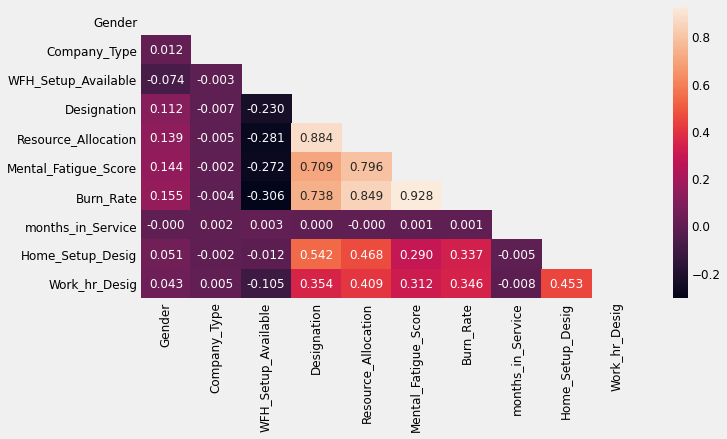

In [29]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True, fmt='.3f', mask=np.triu(train.corr()), square=False);

Shuffling and splitting data Data

In [30]:
#Setting seed
SEED = 123
np.random.seed(SEED)
random.seed(SEED)

In [31]:
#shuffling data
train = shuffle(train, random_state=SEED)

In [32]:
features = [col for col in train.columns if col not in ['Date_of_Joining', 'Employee_ID', 'Burn_Rate', 'months_in_Service','Company_Type']]
features

['Gender',
 'WFH_Setup_Available',
 'Designation',
 'Resource_Allocation',
 'Mental_Fatigue_Score',
 'Home_Setup_Desig',
 'Work_hr_Desig']

In [33]:
X = train[features]
y = train.Burn_Rate
test_c = test[features]

In [34]:
xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=SEED, test_size=0.3)

In [35]:
xtrain.shape, xval.shape

((15138, 7), (6488, 7))

### Cross Validation scores

In [36]:
crossValScores(RandomForestRegressor(random_state=SEED, n_jobs=-1,min_samples_leaf=3, min_samples_split=2))

R2: 0.904 +- 0.0041


In [37]:
crossValScores(GradientBoostingRegressor(random_state=SEED))

R2: 0.907 +- 0.0046


In [38]:
crossValScores(lgb.LGBMRegressor(random_state=SEED))

R2: 0.911 +- 0.0044


In [39]:
crossValScores(cat.CatBoostRegressor(random_state=SEED, n_estimators=100))

R2: 0.911 +- 0.0042


In [40]:
#Instantiating models
rf= RandomForestRegressor(random_state=SEED, min_samples_leaf=3, min_samples_split=2, 
                          n_jobs=-1,max_samples=0.8, n_estimators=400, max_features=0.6)

gbm = GradientBoostingRegressor(random_state=SEED, min_samples_leaf=1, min_samples_split=2, 
                                max_depth=6, max_features=0.6, n_iter_no_change=100, subsample=0.95,
                                validation_fraction=0.15, n_estimators=500, learning_rate=0.07)

lgbm = lgb.LGBMRegressor(random_state=SEED, colsample_bytree=0.5, subsample=0.95, num_leaves=35,
                         n_estimators=1000, learning_rate=0.04, max_depth=6, min_child_samples=5,
                         metrics='rmse', importance_type='gain', reg_lambda=5)

catm = cat.CatBoostRegressor(random_state=SEED, subsample=0.95, n_estimators=1100, rsm=0.8, od_type='Iter',
                             learning_rate=0.05, eval_metric='RMSE', bootstrap_type='Bernoulli')

#### Training

In [41]:
trainModel(rf);

Train R2: 0.9248    Train RMSE : 0.0543
Val R2: 0.9077    Val RMSE : 0.0603


In [42]:
trainModel(gbm);

Train R2: 0.9185    Train RMSE : 0.0565
Val R2: 0.9106    Val RMSE : 0.0594


In [43]:
trainModel(lgbm);

Train R2: 0.9175    Train RMSE : 0.0569
Val R2: 0.9111    Val RMSE : 0.0592


In [44]:
trainModel(catm);

Train R2: 0.9184    Train RMSE : 0.0566
Val R2: 0.9116    Val RMSE : 0.0590


Plotting

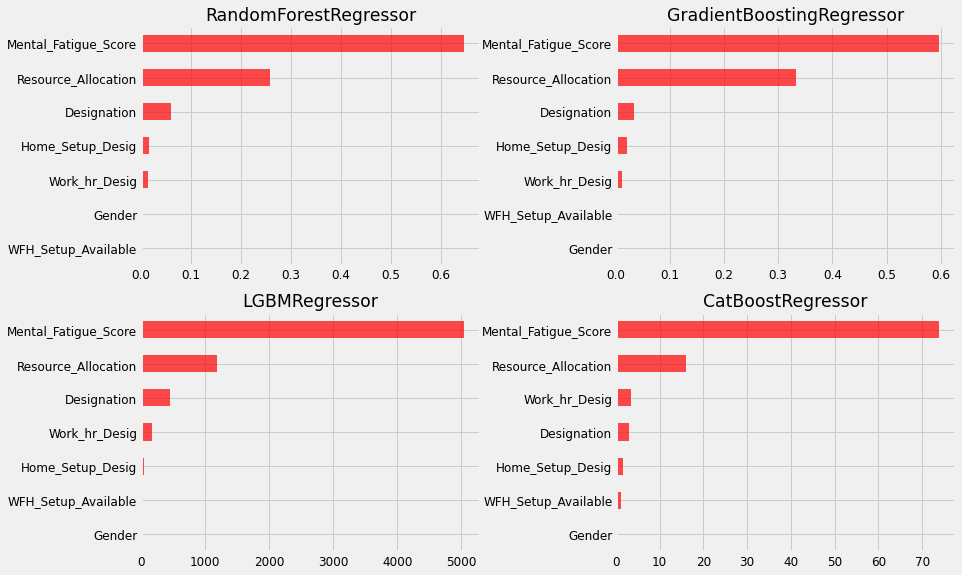

In [47]:
plt.figure(figsize=(13,9))
for i, model in enumerate([rf, gbm, lgbm, catm], start=1):
    plt.subplot(2,2,i)
    featureImportance(model)
plt.subplots_adjust(wspace=0.4);

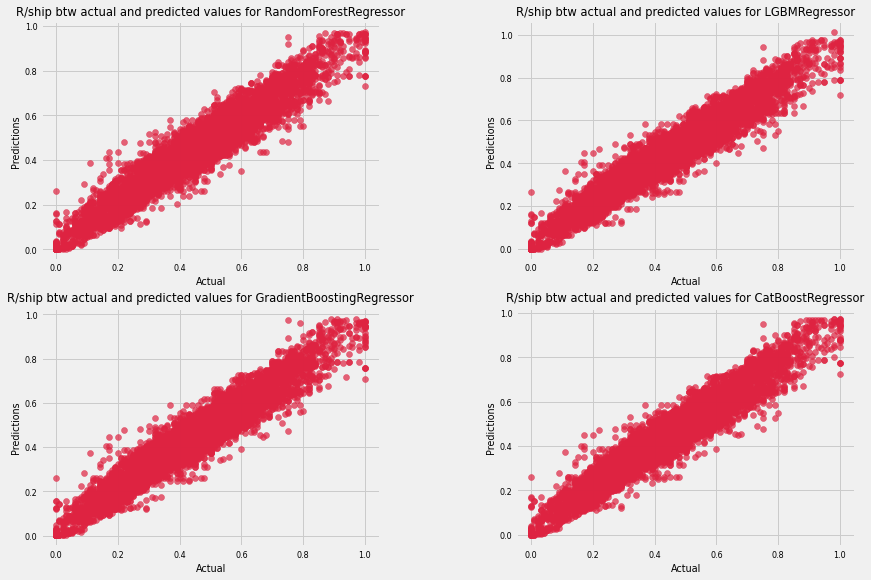

In [48]:
plt.rcParams.update({'font.size':8})
plt.figure(figsize=(13,9))
for i, model in enumerate([rf, lgbm, gbm, catm], start=1):
    plt.subplot(2,2,i)
    explained_VarPlot(model, xval, yval)
plt.subplots_adjust(wspace=0.4, hspace=0.3);

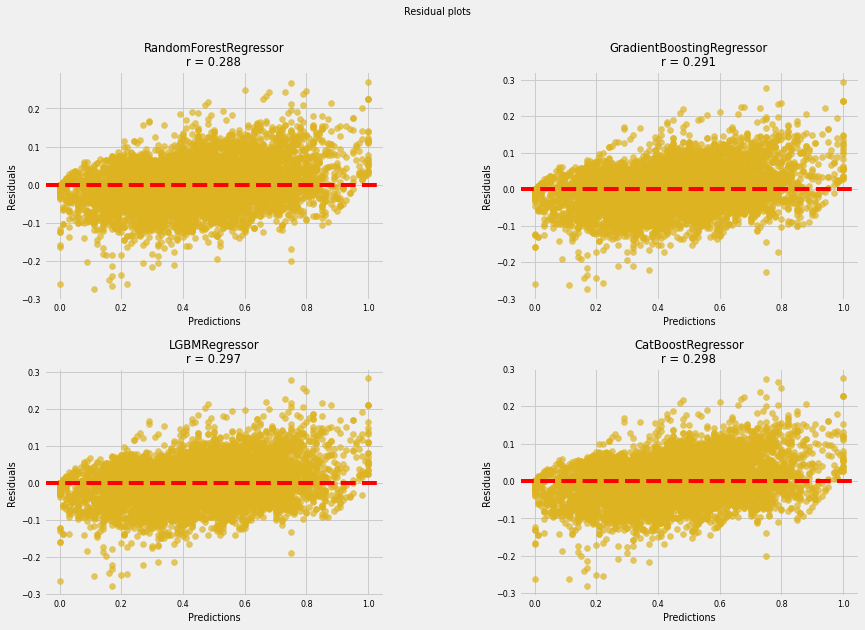

In [50]:
plt.figure(figsize=(13,9))
for i, model in enumerate([rf, gbm, lgbm, catm], start=1):
    plt.subplot(2,2,i)
    residual_plots(model, xval, yval)
plt.subplots_adjust(wspace=0.4, hspace=0.3);

#### Test Predictions and Submission

In [51]:
kfold = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [52]:
rf_pred= kfold_pred(rf, test_c)

Fold 1
Train R2: 0.9236    Train RMSE : 0.0547
Val R2: 0.9078    Val RMSE : 0.0608

Fold 2
Train R2: 0.9236    Train RMSE : 0.0548
Val R2: 0.9057    Val RMSE : 0.0607

Fold 3
Train R2: 0.9234    Train RMSE : 0.0549
Val R2: 0.9083    Val RMSE : 0.0598

Fold 4
Train R2: 0.9237    Train RMSE : 0.0547
Val R2: 0.9060    Val RMSE : 0.0613

Fold 5
Train R2: 0.9231    Train RMSE : 0.0550
Val R2: 0.9117    Val RMSE : 0.0589

Fold 6
Train R2: 0.9237    Train RMSE : 0.0548
Val R2: 0.9061    Val RMSE : 0.0604

Fold 7
Train R2: 0.9231    Train RMSE : 0.0549
Val R2: 0.9118    Val RMSE : 0.0596

Fold 8
Train R2: 0.9232    Train RMSE : 0.0549
Val R2: 0.9106    Val RMSE : 0.0593

Fold 9
Train R2: 0.9238    Train RMSE : 0.0547
Val R2: 0.9045    Val RMSE : 0.0615

Fold 10
Train R2: 0.9240    Train RMSE : 0.0548
Val R2: 0.9017    Val RMSE : 0.0605

Avg R2 : 0.907      Avg RMSE: 0.060


In [53]:
gbm_pred = kfold_pred(gbm, test_c)

Fold 1
Train R2: 0.9175    Train RMSE : 0.0569
Val R2: 0.9118    Val RMSE : 0.0594

Fold 2
Train R2: 0.9178    Train RMSE : 0.0569
Val R2: 0.9092    Val RMSE : 0.0596

Fold 3
Train R2: 0.9175    Train RMSE : 0.0570
Val R2: 0.9109    Val RMSE : 0.0590

Fold 4
Train R2: 0.9179    Train RMSE : 0.0567
Val R2: 0.9099    Val RMSE : 0.0601

Fold 5
Train R2: 0.9173    Train RMSE : 0.0570
Val R2: 0.9144    Val RMSE : 0.0580

Fold 6
Train R2: 0.9178    Train RMSE : 0.0569
Val R2: 0.9102    Val RMSE : 0.0591

Fold 7
Train R2: 0.9172    Train RMSE : 0.0569
Val R2: 0.9162    Val RMSE : 0.0581

Fold 8
Train R2: 0.9171    Train RMSE : 0.0571
Val R2: 0.9155    Val RMSE : 0.0577

Fold 9
Train R2: 0.9180    Train RMSE : 0.0567
Val R2: 0.9087    Val RMSE : 0.0601

Fold 10
Train R2: 0.9182    Train RMSE : 0.0569
Val R2: 0.9056    Val RMSE : 0.0593

Avg R2 : 0.911      Avg RMSE: 0.059


In [54]:
lgbm_pred = kfold_pred(lgbm, test_c)

Fold 1
Train R2: 0.9155    Train RMSE : 0.0575
Val R2: 0.9128    Val RMSE : 0.0591

Fold 2
Train R2: 0.9158    Train RMSE : 0.0575
Val R2: 0.9100    Val RMSE : 0.0593

Fold 3
Train R2: 0.9172    Train RMSE : 0.0570
Val R2: 0.9116    Val RMSE : 0.0588

Fold 4
Train R2: 0.9154    Train RMSE : 0.0576
Val R2: 0.9101    Val RMSE : 0.0600

Fold 5
Train R2: 0.9170    Train RMSE : 0.0571
Val R2: 0.9145    Val RMSE : 0.0580

Fold 6
Train R2: 0.9151    Train RMSE : 0.0578
Val R2: 0.9113    Val RMSE : 0.0587

Fold 7
Train R2: 0.9161    Train RMSE : 0.0574
Val R2: 0.9166    Val RMSE : 0.0579

Fold 8
Train R2: 0.9161    Train RMSE : 0.0574
Val R2: 0.9159    Val RMSE : 0.0575

Fold 9
Train R2: 0.9178    Train RMSE : 0.0568
Val R2: 0.9083    Val RMSE : 0.0602

Fold 10
Train R2: 0.9165    Train RMSE : 0.0574
Val R2: 0.9058    Val RMSE : 0.0592

Avg R2 : 0.912      Avg RMSE: 0.059


In [55]:
catm_pred = kfold_pred(catm, test_c)

Fold 1
Train R2: 0.9159    Train RMSE : 0.0574
Val R2: 0.9127    Val RMSE : 0.0591

Fold 2
Train R2: 0.9173    Train RMSE : 0.0570
Val R2: 0.9101    Val RMSE : 0.0593

Fold 3
Train R2: 0.9173    Train RMSE : 0.0570
Val R2: 0.9121    Val RMSE : 0.0586

Fold 4
Train R2: 0.9157    Train RMSE : 0.0575
Val R2: 0.9104    Val RMSE : 0.0599

Fold 5
Train R2: 0.9170    Train RMSE : 0.0571
Val R2: 0.9154    Val RMSE : 0.0576

Fold 6
Train R2: 0.9138    Train RMSE : 0.0582
Val R2: 0.9120    Val RMSE : 0.0585

Fold 7
Train R2: 0.9159    Train RMSE : 0.0574
Val R2: 0.9172    Val RMSE : 0.0577

Fold 8
Train R2: 0.9156    Train RMSE : 0.0576
Val R2: 0.9167    Val RMSE : 0.0573

Fold 9
Train R2: 0.9181    Train RMSE : 0.0567
Val R2: 0.9091    Val RMSE : 0.0600

Fold 10
Train R2: 0.9164    Train RMSE : 0.0575
Val R2: 0.9065    Val RMSE : 0.0590

Avg R2 : 0.912      Avg RMSE: 0.059


In [56]:
blend = 0.3*gbm_pred + 0.25 * lgbm_pred + 0.45*catm_pred

In [59]:
rf_df = pd.DataFrame({'Employee ID' : employee_id, 'Burn Rate' : rf_pred})
gbm_df = pd.DataFrame({'Employee ID' : employee_id, 'Burn Rate' : gbm_pred})
lgbm_df = pd.DataFrame({'Employee ID' : employee_id, 'Burn Rate' : lgbm_pred})
catm_df = pd.DataFrame({'Employee ID' : employee_id, 'Burn Rate' : catm_pred})
blend_df = pd.DataFrame({'Employee ID' : employee_id, 'Burn Rate' : blend})

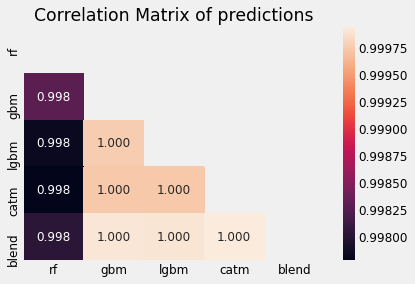

In [60]:
plt.rcParams.update({'font.size':12})
scores = pd.DataFrame(np.c_[rf_pred, gbm_pred, lgbm_pred, catm_pred, blend], 
                      columns=['rf', 'gbm', 'lgbm', 'catm', 'blend'])
sns.heatmap(scores.corr(), annot=True, fmt='.3f', mask=np.triu(scores.corr()))
plt.title('Correlation Matrix of predictions');

In [61]:
# os.mkdir(path+'./Employee_BurnOut/preds')
path2= path+'./Employee_BurnOut/preds'

In [62]:
rf_df.to_csv(path2+'./rf3.csv',index=False)
gbm_df.to_csv(path2+'./gbm3.csv',index=False)
lgbm_df.to_csv(path2+'./lgbm3.csv',index=False)
catm_df.to_csv(path2+'./catm3.csv',index=False)
blend_df.to_csv(path2+'./blend3.csv',index=False)

<h4 style='color:white'> LeaderBoard Scores</h4>
<table style='width:50%; font-size:1.01em'>
    <tr>
        <th style='text-align:left;'>Model</th>
        <th  style='text-align:left;'>Public LB</th>
    <tr>
        <td>RF</td>
        <td>92.74685</td></tr>
    <tr>
        <td>GB</td>
        <td>93.07923</td></tr>
    <tr>
        <td>LGBM</td>
        <td>93.05687</td></tr>
    <tr>
        <td>CATM</td>
        <td>93.08944</td></tr>
    <tr>
        <td>BLEND</td>
        <td>93.09317</td></tr>
</table>